=== INPUT (from CSV) ===
Weeks in history: 12
Tasks/week history: [0, 2, 0, 1, 1, 1, 0, 2, 2, 4, 5, 0]
Hours/week history (from 'Затраченное время'): [4.1, 9.1, 2.7, 3.6, 3.0, 3.5, 3.9, 5.0, 5.3, 8.9, 6.8, 0.0]

=== MONTE CARLO RESULTS ===
Model 1 (tasks/week)      : mean=4.70 weeks, P80=6 weeks
Model 2 (hours/week+tri)  : mean=11.88 weeks, P80=14 weeks
ΔP80 (M2-M1)     : +8 weeks


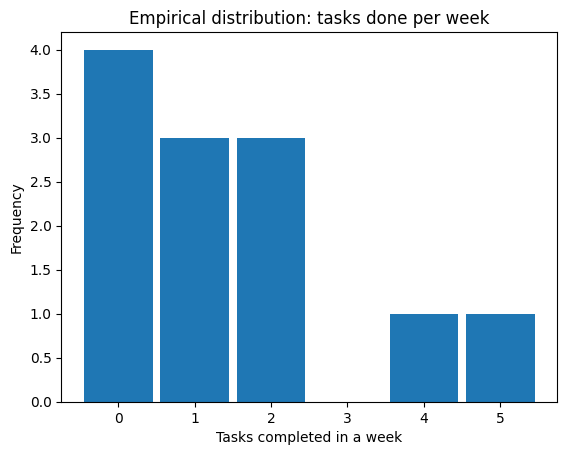

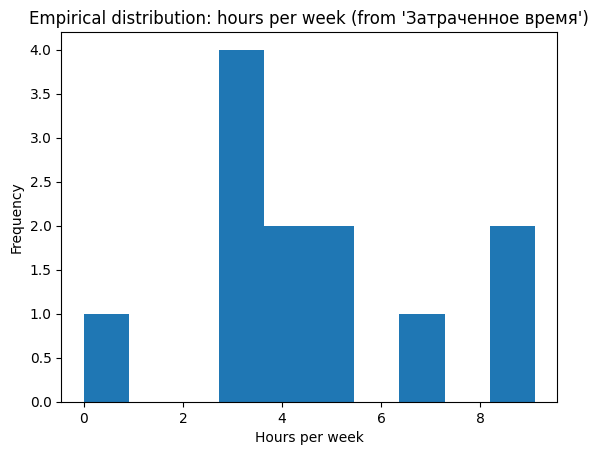

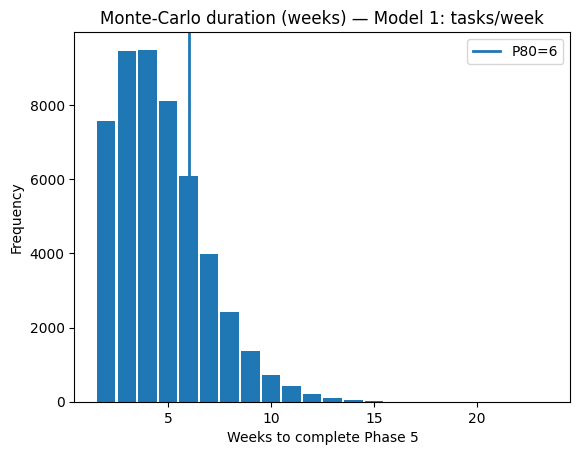

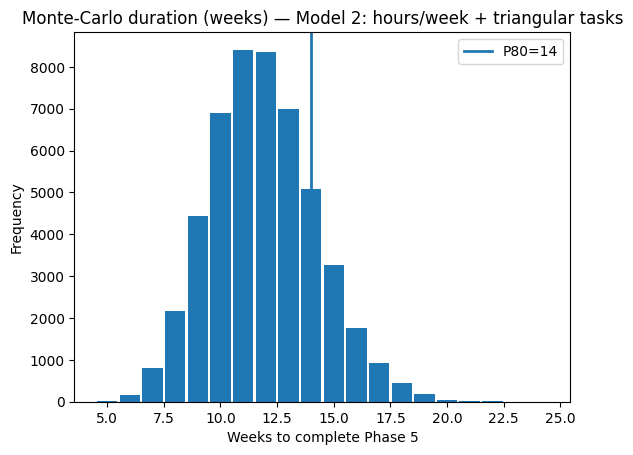

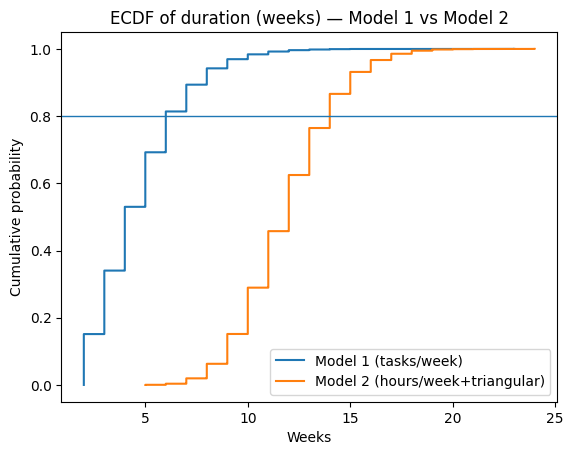

In [5]:
"""
Фаза 4 — Монте-Карло прогноз выполнения Фазы 5 (2 модели) + графики
Импорт истории из CSV (Jira-like) с колонками дат + ЗАТРАЧЕННОЕ ВРЕМЯ (часы).

Ожидаемые колонки в CSV:
- "Start date"              : фактический старт задачи (дата/время или дата)
- "Срок исполнения"         : фактическое завершение задачи (дата/время или дата)
- "Затраченное время"       : фактические трудозатраты по задаче в ЧАСАХ (float/int)

Модель 1 (tasks/week):
- строим дискретное распределение tasks_done_per_week_history по фактическим завершениям.

Модель 2 (hours/week + triangular):
- строим дискретное распределение hours_per_week_history из фактических часов:
  суммируем "Затраченное время" по неделям, распределяя равномерно по дням
  интервала [Start date, Срок исполнения] (если интервал неизвестен/нулевой —
  относим часы к неделе завершения).
- в симуляции:
  - длительность каждой задачи Фазы 5 сэмплим из triangular(O, M, P) (в днях)
  - переводим в часы (×8)
  - каждую неделю вычитаем случайную ёмкость из hours_per_week_history

Графики:
- Эмпирические распределения tasks/week и hours/week
- Гистограммы распределения срока (в неделях) для обеих моделей
- ECDF (кумулятивная) для обеих моделей + отметка P80

Зависимости: pandas, numpy, matplotlib
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# НАСТРОЙКИ
# -----------------------------
CSV_PATH = "sprints_1.csv"  # <-- поменяй на свой файл при необходимости

SEMESTER_START = pd.Timestamp("2025-09-10")
SEMESTER_END   = pd.Timestamp("2025-11-24")

HOURS_PER_DAY = 8
N_SIM = 50_000
PERCENTILE = 80

# 6 задач Фазы 5 (три точки в ДНЯХ)
phase5_tasks_three_point = [
    ("T1 Structure & Work list", 0.25, 0.75, 1.50),
    ("T2 Roles & Resources",     0.10, 0.30, 0.75),
    ("T3 Duration & Resources",  0.50, 1.50, 3.00),
    ("T4 Dependencies",          0.50, 1.25, 2.50),
    ("T5 Run Heuristics",        0.50, 1.25, 2.50),
    ("T6 Final Plan & Analysis", 0.25, 0.75, 1.50),
]


# -----------------------------
# УТИЛИТЫ
# -----------------------------
def to_datetime_safe(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", utc=False)

def week_key(ts: pd.Timestamp) -> pd.Timestamp:
    """Метка недели = понедельник этой недели."""
    return (ts - pd.Timedelta(days=ts.weekday())).normalize()

def build_week_index(start: pd.Timestamp, end: pd.Timestamp) -> pd.DatetimeIndex:
    start_w = week_key(start)
    end_w = week_key(end)
    return pd.date_range(start_w, end_w, freq="W-MON")

def ecdf(values: np.ndarray):
    x = np.sort(values)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def pctl(values: np.ndarray, p: float) -> float:
    return float(np.percentile(values, p))


# -----------------------------
# 1) ИМПОРТ CSV + подготовка истории
# -----------------------------
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

required_cols = ["Start date", "Срок исполнения", "Затраченное время"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(
        f"В CSV нет обязательных колонок: {missing}. "
        f"Проверь названия. Доступные колонки: {list(df.columns)}"
    )

df["Start date"] = to_datetime_safe(df["Start date"])
df["Срок исполнения"] = to_datetime_safe(df["Срок исполнения"])
df["Затраченное время"] = pd.to_numeric(df["Затраченное время"], errors="coerce")

# Оставим только задачи, которые закончились в семестре
df_sem = df[(df["Срок исполнения"] >= SEMESTER_START) & (df["Срок исполнения"] <= SEMESTER_END)].copy()

weeks = build_week_index(SEMESTER_START, SEMESTER_END)

# -----------------------------
# История для МОДЕЛИ 1: tasks_done_per_week_history
# -----------------------------
tasks_per_week = pd.Series(0, index=weeks)
for done_dt in df_sem["Срок исполнения"].dropna():
    wk = week_key(done_dt)
    if wk in tasks_per_week.index:
        tasks_per_week.loc[wk] += 1
tasks_done_per_week_history = tasks_per_week.values.astype(int)

if np.all(tasks_done_per_week_history == 0):
    raise ValueError("tasks_done_per_week_history получился из одних нулей — проверь даты завершения в CSV.")

# -----------------------------
# История для МОДЕЛИ 2: hours_per_week_history (ИСПОЛЬЗУЕМ 'Затраченное время')
# -----------------------------
hours_per_week = pd.Series(0.0, index=weeks)

def distribute_hours_over_interval(start_dt: pd.Timestamp, end_dt: pd.Timestamp, hours: float):
    """
    Равномерно распределяет 'hours' по дням интервала [start_dt, end_dt] включительно
    и добавляет в hours_per_week по неделям.
    Если интервал невалиден/нулевой — отнесём все часы на неделю завершения.
    """
    if hours is None or np.isnan(hours) or hours <= 0:
        return

    # Если нет дат — игнор
    if pd.isna(end_dt) and pd.isna(start_dt):
        return

    # Если нет старта — считаем, что всё в неделю завершения
    if pd.isna(start_dt) and not pd.isna(end_dt):
        wk = week_key(end_dt)
        if wk in hours_per_week.index:
            hours_per_week.loc[wk] += float(hours)
        return

    # Если нет завершения — считаем, что всё в неделю старта
    if pd.isna(end_dt) and not pd.isna(start_dt):
        wk = week_key(start_dt)
        if wk in hours_per_week.index:
            hours_per_week.loc[wk] += float(hours)
        return

    # Обе даты есть
    s = start_dt.normalize()
    e = end_dt.normalize()

    if e < s:
        # странные данные -> всё в неделю завершения
        wk = week_key(end_dt)
        if wk in hours_per_week.index:
            hours_per_week.loc[wk] += float(hours)
        return

    # Ограничиваем семестром
    s = max(s, SEMESTER_START.normalize())
    e = min(e, SEMESTER_END.normalize())
    if e < s:
        return

    days = (e - s).days + 1
    if days <= 0:
        wk = week_key(end_dt)
        if wk in hours_per_week.index:
            hours_per_week.loc[wk] += float(hours)
        return

    per_day = float(hours) / days
    for i in range(days):
        d = s + pd.Timedelta(days=i)
        wk = week_key(d)
        if wk in hours_per_week.index:
            hours_per_week.loc[wk] += per_day

# применяем распределение часов
for _, row in df_sem.iterrows():
    distribute_hours_over_interval(row["Start date"], row["Срок исполнения"], row["Затраченное время"])

hours_per_week_history = hours_per_week.values

if np.all(hours_per_week_history == 0):
    raise ValueError("hours_per_week_history получился из одних нулей — проверь 'Затраченное время' в CSV.")


# -----------------------------
# 2) СИМУЛЯЦИЯ МОДЕЛЬ 1 (tasks/week)
# -----------------------------
def simulate_model_1(n_tasks: int, tasks_done_dist: np.ndarray) -> int:
    remaining = n_tasks
    weeks_count = 0

    # если в распределении бывают недели 0 задач — это нормально.
    # но если распределение состоит только из 0 — бесконечность (мы это уже проверили выше)

    while remaining > 0:
        done = int(np.random.choice(tasks_done_dist))
        remaining -= done
        weeks_count += 1

    return weeks_count


# -----------------------------
# 3) СИМУЛЯЦИЯ МОДЕЛЬ 2 (hours/week + triangular task durations)
# -----------------------------
def simulate_model_2(tasks_three_point, hours_capacity_dist: np.ndarray) -> int:
    # сэмплим трудоёмкость фазы 5 (в часах)
    total_hours = 0.0
    for _, o, m, p in tasks_three_point:
        dur_days = np.random.triangular(o, m, p)
        total_hours += dur_days * HOURS_PER_DAY

    remaining = total_hours
    weeks_count = 0

    while remaining > 0:
        cap = float(np.random.choice(hours_capacity_dist))
        remaining -= cap
        weeks_count += 1

    return weeks_count


# -----------------------------
# 4) ЗАПУСК СИМУЛЯЦИЙ
# -----------------------------
np.random.seed(42)

n_phase5_tasks = len(phase5_tasks_three_point)

m1 = np.array([simulate_model_1(n_phase5_tasks, tasks_done_per_week_history) for _ in range(N_SIM)], dtype=float)
m1_p80 = pctl(m1, PERCENTILE)

m2 = np.array([simulate_model_2(phase5_tasks_three_point, hours_per_week_history) for _ in range(N_SIM)], dtype=float)
m2_p80 = pctl(m2, PERCENTILE)

print("=== INPUT (from CSV) ===")
print("Weeks in history:", len(weeks))
print("Tasks/week history:", tasks_done_per_week_history.tolist())
print("Hours/week history (from 'Затраченное время'):", [round(x, 1) for x in hours_per_week_history.tolist()])
print()

print("=== MONTE CARLO RESULTS ===")
print(f"Model 1 (tasks/week)      : mean={m1.mean():.2f} weeks, P{PERCENTILE}={m1_p80:.0f} weeks")
print(f"Model 2 (hours/week+tri)  : mean={m2.mean():.2f} weeks, P{PERCENTILE}={m2_p80:.0f} weeks")
print(f"ΔP{PERCENTILE} (M2-M1)     : {m2_p80 - m1_p80:+.0f} weeks")


# -----------------------------
# 5) ГРАФИКИ
# -----------------------------

# 5.1 Эмпирическое распределение tasks/week
plt.figure()
plt.title("Empirical distribution: tasks done per week")
plt.hist(tasks_done_per_week_history,
         bins=np.arange(tasks_done_per_week_history.min(), tasks_done_per_week_history.max() + 2) - 0.5,
         rwidth=0.9)
plt.xlabel("Tasks completed in a week")
plt.ylabel("Frequency")
plt.show()

# 5.2 Эмпирическое распределение hours/week
plt.figure()
plt.title("Empirical distribution: hours per week (from 'Затраченное время')")
plt.hist(hours_per_week_history, bins=10)
plt.xlabel("Hours per week")
plt.ylabel("Frequency")
plt.show()

# 5.3 Гистограмма срока по Модели 1
plt.figure()
plt.title("Monte-Carlo duration (weeks) — Model 1: tasks/week")
plt.hist(m1, bins=np.arange(int(m1.min()), int(m1.max()) + 2) - 0.5, rwidth=0.9)
plt.axvline(m1_p80, linewidth=2, label=f"P{PERCENTILE}={m1_p80:.0f}")
plt.xlabel("Weeks to complete Phase 5")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 5.4 Гистограмма срока по Модели 2
plt.figure()
plt.title("Monte-Carlo duration (weeks) — Model 2: hours/week + triangular tasks")
plt.hist(m2, bins=np.arange(int(m2.min()), int(m2.max()) + 2) - 0.5, rwidth=0.9)
plt.axvline(m2_p80, linewidth=2, label=f"P{PERCENTILE}={m2_p80:.0f}")
plt.xlabel("Weeks to complete Phase 5")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 5.5 ECDF сравнение + P80
def ecdf(values: np.ndarray):
    x = np.sort(values)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

x1, y1 = ecdf(m1)
x2, y2 = ecdf(m2)

plt.figure()
plt.title("ECDF of duration (weeks) — Model 1 vs Model 2")
plt.step(x1, y1, where="post", label="Model 1 (tasks/week)")
plt.step(x2, y2, where="post", label="Model 2 (hours/week+triangular)")
plt.axhline(PERCENTILE/100, linewidth=1)
plt.xlabel("Weeks")
plt.ylabel("Cumulative probability")
plt.legend()
plt.show()
